# DOWNLOAD THE DATASET

In [1]:
import GEOparse
import pandas as pd

import os

# Create necessary directories
os.makedirs('./data', exist_ok=True)
os.makedirs('./results', exist_ok=True)
os.makedirs('./figures', exist_ok=True)

# Download GSE147507 from GEO
gse = GEOparse.get_GEO(geo="GSE147507", destdir="./data/")

# Examine the dataset
print("Dataset info:")
print(f"Title: {gse.metadata['title'][0]}")
print(f"Samples: {len(gse.gsms)}")
print("\nSample names:")
for gsm_name, gsm in gse.gsms.items():
    print(f"{gsm_name}: {gsm.metadata['title'][0]}")

21-Jan-2026 14:58:31 DEBUG utils - Directory ./data/ already exists. Skipping.
21-Jan-2026 14:58:31 INFO GEOparse - File already exist: using local version.
21-Jan-2026 14:58:31 INFO GEOparse - Parsing ./data/GSE147507_family.soft.gz: 
21-Jan-2026 14:58:31 DEBUG GEOparse - DATABASE: GeoMiame
21-Jan-2026 14:58:31 DEBUG GEOparse - SERIES: GSE147507
21-Jan-2026 14:58:31 DEBUG GEOparse - PLATFORM: GPL18573
21-Jan-2026 14:58:31 DEBUG GEOparse - PLATFORM: GPL28369
21-Jan-2026 14:58:31 DEBUG GEOparse - SAMPLE: GSM4432378
21-Jan-2026 14:58:31 DEBUG GEOparse - SAMPLE: GSM4432379
21-Jan-2026 14:58:31 DEBUG GEOparse - SAMPLE: GSM4432380
21-Jan-2026 14:58:31 DEBUG GEOparse - SAMPLE: GSM4432381
21-Jan-2026 14:58:31 DEBUG GEOparse - SAMPLE: GSM4432382
21-Jan-2026 14:58:31 DEBUG GEOparse - SAMPLE: GSM4432383
21-Jan-2026 14:58:31 DEBUG GEOparse - SAMPLE: GSM4432384
21-Jan-2026 14:58:31 DEBUG GEOparse - SAMPLE: GSM4432385
21-Jan-2026 14:58:31 DEBUG GEOparse - SAMPLE: GSM4432386
21-Jan-2026 14:58:31 DEB

Dataset info:
Title: Transcriptional response to SARS-CoV-2 infection
Samples: 110

Sample names:
GSM4432378: Series1_NHBE_Mock_1
GSM4432379: Series1_NHBE_Mock_2
GSM4432380: Series1_NHBE_Mock_3
GSM4432381: Series1_NHBE_SARS-CoV-2_1
GSM4432382: Series1_NHBE_SARS-CoV-2_2
GSM4432383: Series1_NHBE_SARS-CoV-2_3
GSM4432384: Series2_A549_Mock_1
GSM4432385: Series2_A549_Mock_2
GSM4432386: Series2_A549_Mock_3
GSM4432387: Series2_A549_SARS-CoV-2_1
GSM4432388: Series2_A549_SARS-CoV-2_2
GSM4432389: Series2_A549_SARS-CoV-2_3
GSM4432390: Series3_A549_Mock_1
GSM4432391: Series3_A549_Mock_2
GSM4432392: Series3_A549_RSV_1
GSM4432393: Series3_A549_RSV_2
GSM4432394: Series4_A549_Mock_1
GSM4432395: Series4_A549_Mock_2
GSM4432396: Series4_A549_IAV_1
GSM4432397: Series4_A549_IAV_2
GSM4462336: Series5_A549_Mock_1
GSM4462337: Series5_A549_Mock_2
GSM4462338: Series5_A549_Mock_3
GSM4462339: Series5_A549_SARS-CoV-2_1
GSM4462340: Series5_A549_SARS-CoV-2_2
GSM4462341: Series5_A549_SARS-CoV-2_3
GSM4462342: Series6_

In [2]:
# Check how data is stored in this dataset
first_sample = list(gse.gsms.values())[0]
print("Sample metadata keys:", first_sample.metadata.keys())
print("\nChecking for supplementary files:")
print("Supplementary files:", first_sample.metadata.get('supplementary_file', 'None'))
print("\nData table type:", type(first_sample.table))
print("Columns:", first_sample.table.columns.tolist() if hasattr(first_sample.table, 'columns') else 'No columns')

# Check the GSE level
print("\nGSE supplementary files:")
print(gse.metadata.get('supplementary_file', 'None'))

Sample metadata keys: dict_keys(['title', 'geo_accession', 'status', 'submission_date', 'last_update_date', 'type', 'channel_count', 'source_name_ch1', 'organism_ch1', 'taxid_ch1', 'characteristics_ch1', 'molecule_ch1', 'extract_protocol_ch1', 'description', 'data_processing', 'platform_id', 'contact_name', 'contact_laboratory', 'contact_department', 'contact_institute', 'contact_address', 'contact_city', 'contact_state', 'contact_zip/postal_code', 'contact_country', 'instrument_model', 'library_selection', 'library_source', 'library_strategy', 'relation', 'supplementary_file_1', 'series_id', 'data_row_count'])

Checking for supplementary files:
Supplementary files: None

Data table type: <class 'pandas.core.frame.DataFrame'>
Columns: []

GSE supplementary files:
['ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE147nnn/GSE147507/suppl/GSE147507_RawReadCounts_Ferret.tsv.gz', 'ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE147nnn/GSE147507/suppl/GSE147507_RawReadCounts_Human.tsv.gz']


# Load and Prepare the Data

In [4]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
import gzip
import shutil

# Download the raw counts file
print("Downloading raw count data...")
url = "ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE147nnn/GSE147507/suppl/GSE147507_RawReadCounts_Human.tsv.gz"
local_gz = "./data/raw_counts.tsv.gz"
local_tsv = "./data/raw_counts.tsv"

# Download
urllib.request.urlretrieve(url, local_gz)

# Unzip
with gzip.open(local_gz, 'rb') as f_in:
    with open(local_tsv, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

print("Loading expression data...")
expr_df = pd.read_csv(local_tsv, sep='\t', index_col=0)

print(f"Expression matrix shape: {expr_df.shape}")
print(f"\nColumn names (samples):\n{expr_df.columns.tolist()}")
print(f"\nFirst few rows:\n{expr_df.head()}")

# Create sample info based on column names
sample_info = []
for col in expr_df.columns:
    if 'SARS' in col or 'CoV' in col:
        condition = 'Infected'
    elif 'Mock' in col or 'Series' in col:
        condition = 'Mock'
    else:
        condition = 'Unknown'
    sample_info.append({'Sample': col, 'Condition': condition})

sample_df = pd.DataFrame(sample_info)
print(f"\nSample conditions:\n{sample_df}")

# Save
expr_df.to_csv('./data/raw_expression.csv')
sample_df.to_csv('./data/sample_info.csv', index=False)

URLError: <urlopen error [Errno 11002] getaddrinfo failed>

# Quality Control & Normalization

In [ ]:
# Filter low-expressed genes (must have >10 reads in at least 3 samples)
expr_filtered = expr_df[(expr_df > 10).sum(axis=1) >= 3]
print(f"Genes after filtering: {expr_filtered.shape[0]}")

# Log2 transform (add pseudocount to avoid log(0))
expr_log2 = np.log2(expr_filtered + 1)

# Create QC plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Boxplot of distributions
expr_log2.boxplot(ax=axes[0], rot=90)
axes[0].set_title('Expression Distribution (log2)')
axes[0].set_ylabel('log2(counts + 1)')

# Sample correlation heatmap
corr_matrix = expr_log2.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', ax=axes[1])
axes[1].set_title('Sample Correlation')

plt.tight_layout()
plt.savefig('./figures/qc_plots.png', dpi=300, bbox_inches='tight')
print("QC plots saved!")

# Differential Expression Analysis

In [ ]:
# CORRECTED: Separate infected vs mock samples
# Only "Mock" samples go to mock, only "SARS-CoV-2" (without Mock) go to infected
mock_cols = [col for col in expr_filtered.columns if 'Mock' in col]
infected_cols = [col for col in expr_filtered.columns if 'SARS-CoV-2' in col and col not in mock_cols]

print(f"\nInfected samples ({len(infected_cols)}): {infected_cols}")
print(f"\nMock samples ({len(mock_cols)}): {mock_cols}")

# Verify no overlap
overlap = set(infected_cols) & set(mock_cols)
assert len(overlap) == 0, f"ERROR: Samples in both groups: {overlap}"
print("✓ Samples correctly separated!\n")

infected = expr_filtered[infected_cols]
mock = expr_filtered[mock_cols]

# Calculate statistics for each gene
de_results = []

for gene in expr_filtered.index:
    infected_vals = infected.loc[gene].values
    mock_vals = mock.loc[gene].values

    # Calculate means with pseudocount
    mean_infected = np.mean(infected_vals) + 1
    mean_mock = np.mean(mock_vals) + 1

    fold_change = mean_infected / mean_mock
    log2fc = np.log2(fold_change)

    # T-test
    t_stat, p_value = stats.ttest_ind(infected_vals, mock_vals)

    de_results.append({
        'Gene': gene,
        'Mean_Infected': mean_infected,
        'Mean_Mock': mean_mock,
        'FoldChange': fold_change,
        'Log2FC': log2fc,
        'P_value': p_value
    })

# Create results dataframe
de_df = pd.DataFrame(de_results)

# Remove any infinite or NaN values
de_df = de_df.replace([np.inf, -np.inf], np.nan).dropna()
print(f"Genes after removing inf/nan: {len(de_df)}")

# Adjust p-values
de_df['Adjusted_P'] = multipletests(de_df['P_value'], method='fdr_bh')[1]
de_df['-log10(p)'] = -np.log10(de_df['Adjusted_P'])

# Classify genes
de_df['Regulation'] = 'Not Significant'
de_df.loc[(de_df['Log2FC'] > 1) & (de_df['Adjusted_P'] < 0.05), 'Regulation'] = 'Up'
de_df.loc[(de_df['Log2FC'] < -1) & (de_df['Adjusted_P'] < 0.05), 'Regulation'] = 'Down'

print("\n" + "="*50)
print("DIFFERENTIAL EXPRESSION RESULTS")
print("="*50)
print(de_df['Regulation'].value_counts())
print(f"\nTop 10 upregulated:")
print(de_df[de_df['Regulation'] == 'Up'].nlargest(10, 'Log2FC')[['Gene', 'Log2FC', 'Adjusted_P']])

de_df.to_csv('./results/differential_expression_results.csv', index=False)
print("\n✅ Results saved!")

In [ ]:
# Check your DE results
print("\n" + "="*60)
print("YOUR FINAL DIFFERENTIAL EXPRESSION RESULTS")
print("="*60)
print(f"Total genes analyzed: {len(de_df)}")
print(f"\nDifferentially Expressed Genes (|Log2FC| > 1, adj.p < 0.05):")
print(de_df['Regulation'].value_counts())
print(f"\n📊 SUMMARY:")
print(f"   Upregulated: {sum(de_df['Regulation'] == 'Up')} genes")
print(f"   Downregulated: {sum(de_df['Regulation'] == 'Down')} genes")
print(f"   Not significant: {sum(de_df['Regulation'] == 'Not Significant')} genes")

In [ ]:
# Check genes with negative fold changes
print(f"\nGenes with Log2FC < -1: {sum(de_df['Log2FC'] < -1)}")
print(f"Genes with Log2FC < -1 AND adj.p < 0.05: {sum((de_df['Log2FC'] < -1) & (de_df['Adjusted_P'] < 0.05))}")
print(f"\nMost downregulated genes (even if not significant):")
print(de_df.nsmallest(10, 'Log2FC')[['Gene', 'Log2FC', 'Adjusted_P', 'Regulation']])

In [ ]:
# Debug checks
print(f"\nDE Results shape: {de_df.shape}")
print(f"Log2FC range: {de_df['Log2FC'].min()} to {de_df['Log2FC'].max()}")
print(f"P-value range: {de_df['P_value'].min()} to {de_df['P_value'].max()}")
print(f"-log10(p) range: {de_df['-log10(p)'].min()} to {de_df['-log10(p)'].max()}")
print(f"\nAny inf or nan values?")
print(f"Log2FC inf: {np.isinf(de_df['Log2FC']).sum()}")
print(f"Log2FC nan: {de_df['Log2FC'].isna().sum()}")
print(f"-log10(p) inf: {np.isinf(de_df['-log10(p)']).sum()}")
print(f"-log10(p) nan: {de_df['-log10(p)'].isna().sum()}")
print(f"\nFirst few rows of DE results:")
print(de_df[['Gene', 'Log2FC', 'P_value', 'Adjusted_P', '-log10(p)', 'Regulation']].head(10))

# Volcano Plot

NameError: name 'de_df' is not defined

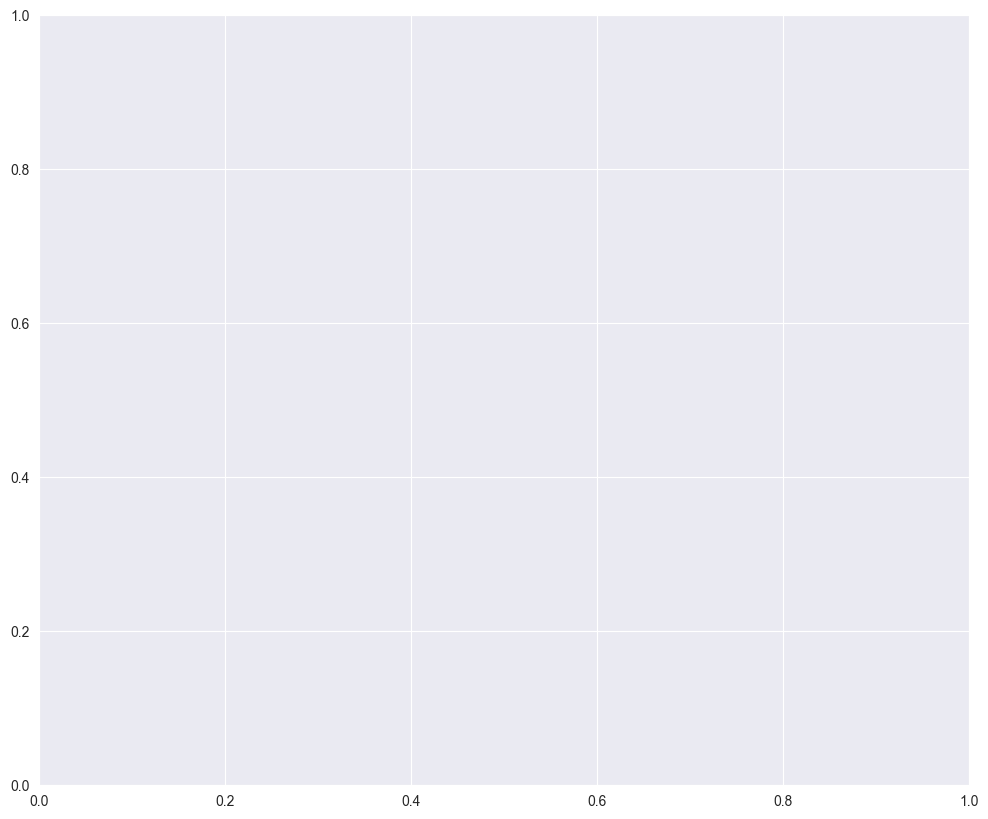

In [5]:
from adjustText import adjust_text

# Create volcano plot with better scaling
fig, ax = plt.subplots(figsize=(12, 10))

# Define colors
colors = {'Up': '#FF6B6B', 'Down': '#4ECDC4', 'Not Significant': '#95A5A6'}

# Plot each group
for regulation in ['Not Significant', 'Down', 'Up']:  # Plot non-sig first so sig points are on top
    subset = de_df[de_df['Regulation'] == regulation]
    ax.scatter(subset['Log2FC'], subset['-log10(p)'],
               c=colors[regulation], label=regulation, alpha=0.6, s=30,
               edgecolors='none')

# Add threshold lines
ax.axhline(y=-np.log10(0.05), color='black', linestyle='--', linewidth=1.5, label='p=0.05')
ax.axvline(x=1, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
ax.axvline(x=-1, color='black', linestyle='--', linewidth=1.5, alpha=0.7)

# Set reasonable axis limits
ax.set_xlim(de_df['Log2FC'].quantile(0.01) - 0.5, de_df['Log2FC'].quantile(0.99) + 0.5)
ax.set_ylim(-0.5, de_df['-log10(p)'].quantile(0.99) + 2)

# Labels and styling
ax.set_xlabel('log₂(Fold Change)', fontsize=14, fontweight='bold')
ax.set_ylabel('-log₁₀(Adjusted P-value)', fontsize=14, fontweight='bold')
ax.set_title('SARS-CoV-2 Differential Gene Expression\nInfected vs Mock',
             fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='upper right', frameon=True, fontsize=11)
ax.grid(True, alpha=0.2, linestyle=':')

plt.tight_layout()
plt.savefig('./figures/volcano_plot.png', dpi=300, bbox_inches='tight')
print(f"\n✅ Volcano plot saved! Found {sum(de_df['Regulation']=='Up')} upregulated and {sum(de_df['Regulation']=='Down')} downregulated genes!")
plt.show()

# Summary Statistics

In [ ]:
# Create summary report
with open('./results/analysis_summary.txt', 'w') as f:
    f.write("SARS-CoV-2 Differential Expression Analysis Summary\n")
    f.write("="*60 + "\n\n")
    f.write(f"Dataset: GSE147507\n")
    f.write(f"Total genes analyzed: {len(de_df)}\n\n")
    f.write("Differentially Expressed Genes (|Log2FC| > 1, adj.p < 0.05):\n")
    f.write(f"  - Upregulated: {sum(de_df['Regulation'] == 'Up')}\n")
    f.write(f"  - Downregulated: {sum(de_df['Regulation'] == 'Down')}\n")
    f.write(f"  - Not significant: {sum(de_df['Regulation'] == 'Not Significant')}\n\n")

    f.write("Top 10 Upregulated Genes:\n")
    top_up = de_df[de_df['Regulation'] == 'Up'].nlargest(10, 'Log2FC')
    for _, row in top_up.iterrows():
        f.write(f"  {row['Gene']}: Log2FC={row['Log2FC']:.2f}, adj.p={row['Adjusted_P']:.2e}\n")

    f.write("\nTop 10 Downregulated Genes:\n")
    top_down = de_df[de_df['Regulation'] == 'Down'].nsmallest(10, 'Log2FC')
    for _, row in top_down.iterrows():
        f.write(f"  {row['Gene']}: Log2FC={row['Log2FC']:.2f}, adj.p={row['Adjusted_P']:.2e}\n")

print("Summary report saved!")

In [ ]:
print(f"Expression data shape: {expr_log2.shape}")
print(f"Sample columns: {expr_log2.columns.tolist()}")
print(f"Any data? {expr_log2.values.sum()}")

In [ ]:
print(f"Infected samples ({len(infected_cols)}): {infected_cols}")
print(f"Mock samples ({len(mock_cols)}): {mock_cols}")
print("\nRegulation counts:")
print(de_df['Regulation'].value_counts())
print(f"\nHow many genes with adj.p < 0.05? {sum(de_df['Adjusted_P'] < 0.05)}")
print(f"How many genes with |Log2FC| > 1? {sum(abs(de_df['Log2FC']) > 1)}")